### 4.3 A Gaussian model of height

In [1]:
import pandas as pd
import numpy as np
import arviz as az  #ArviZ: Exploratory analysis of Bayesian models
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
import seaborn as sns
import pymc3 as pm

##### load the data and create a subset (code 4.10)

In [2]:
df = pd.read_csv('../Data/Howell1.csv', sep=';', header=0)
df.head()
df2 = df[df.age >=18]

In [3]:
#df2.sort_values('age').head()

##### kde of height

Text(0.5, 0, 'Height')

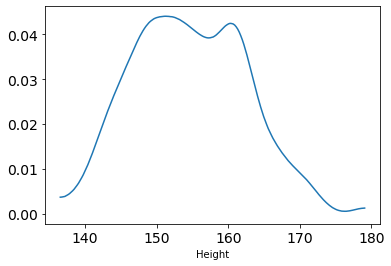

In [4]:
az.plot_kde(df2.height)
plt.xlabel('Height')

##### code 4.11

In [5]:
x = np.linspace(100, 250, num=1000)
y = norm.pdf(x, loc=178, scale=20)

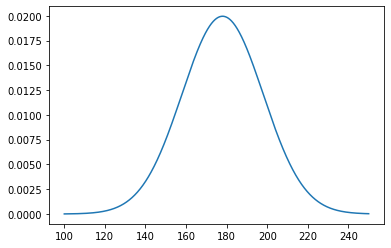

In [6]:
plt.plot(x, y)
plt.show()

##### code 4.12

In [7]:
x = np.linspace(-10, 60, num=100)
y = uniform.pdf(x, loc=0, scale=50)

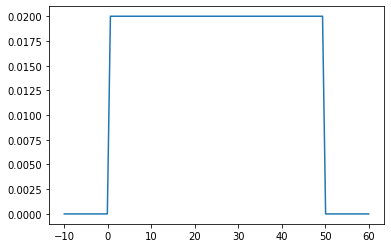

In [8]:
plt.plot(x, y)
plt.show()

##### code 4.13

In [9]:
sample_mu = norm.rvs(loc=178, scale=20, size=int(1e4), random_state=110)
sample_sigma = uniform.rvs(loc=0, scale=50, size=int(1e4), random_state=110)

In [10]:
prior_h = norm.rvs(loc=sample_mu, scale=sample_sigma, size=int(1e4), random_state=110)
# note: It is not clear whether the code above is accurate; that is, it is not clear to me what happens afer passing a  
# vector for loc and a vector for scale. 

Text(0.5, 0, 'prior_h')

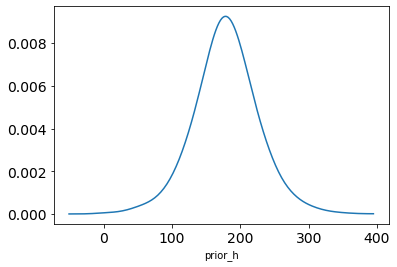

In [11]:
az.plot_kde(prior_h)
plt.xlabel('prior_h')


##### code 4.14. 
##### notice that here, we use log probabilities, instead of probabilities
##### 

In [12]:
#mu_list = np.linspace(140, 160, num=200)
#sigma_list = np.linspace(4, 9, num=200)
#mu_axis, sigma_axis = np.meshgrid(mu_list, sigma_list)
# it seems that np.mgrid is preferred over np.meshgrid, see http://louistiao.me/posts/numpy-mgrid-vs-meshgrid/#id2

In [13]:
post = np.mgrid[140:160:200j, 4:9:200j].reshape(2, -1).T #notice that we need to use mgrid[], instead of ()

In [14]:
log_likelihood = [np.sum(norm.logpdf(df2.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]
log_posterior = log_likelihood + norm.logpdf(post[:, 0], loc=178, scale=20) + uniform.logpdf(post[:, 1], loc=0, scale=50)
posterior = np.exp(log_posterior - max(log_posterior))

In [15]:
posterior_df = pd.DataFrame([post[:, 0],post[:, 1], posterior]).T
posterior_df.columns = ["mu", 'sigma', 'posterior']
posterior_df.head()

,mu,sigma,posterior
0,140.0,4.000000,0.0
1,140.0,4.025126,0.0
2,140.0,4.050251,0.0
3,140.0,4.075377,0.0
4,140.0,4.100503,0.0


##### ! I skip the contour map here (i.e., 4.15, and 4.16). 

##### code 4.17~4.18

In [16]:
sample_rows = np.random.choice(np.arange(len(posterior)), size=int(1e4), replace=True, p=posterior/posterior.sum())

In [17]:
sample_mu = posterior_df.iloc[sample_rows, 0]
sample_sigma = posterior_df.iloc[sample_rows, 1]

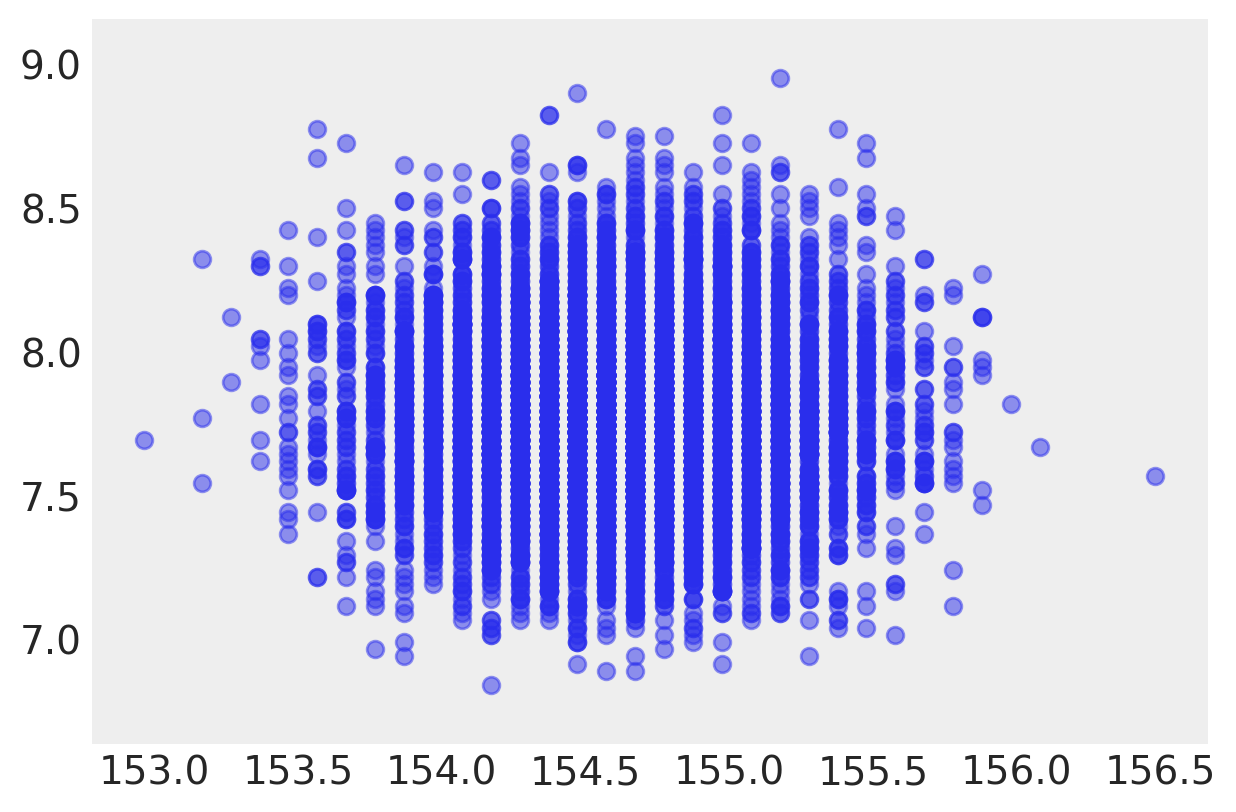

In [18]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
plt.scatter(sample_mu, sample_sigma, marker='o', alpha=0.5)
plt.axis('equal')
plt.grid(False)

### use pymc3 to fit the model (4.3.5)

In [43]:
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    mu = pm.Normal('mu', mu=178, sigma=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)

    # Define likelihood
    likelihood = pm.Normal('height', mu=mu,
                        sigma=sigma, observed=df2.height)

    # Inference!
    trace = pm.sample(3000, cores=2) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:04<00:00, 1483.10draws/s]


##### code 4.26~4.27 maximum a posteriori

In [20]:
map_estimate = pm.find_MAP(model=model)
map_estimate


logp = -1,235.2, ||grad|| = 11.697: 100%|██████████| 19/19 [00:00<00:00, 2913.35it/s]  


{'mu': array(154.60702358),
 'sigma_interval__': array(-1.69876478),
 'sigma': array(7.73133303)}

##### code 4.29 a more informative prior

In [21]:
with pm.Model() as model_1: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    mu = pm.Normal('mu', mu=178, sigma=0.1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)

    # Define likelihood
    likelihood = pm.Normal('height', mu=mu,
                        sigma=sigma, observed=df2.height)

    # Inference!
    trace = pm.sample(3000, cores=2)

map_estimate_1 = pm.find_MAP(model=model_1)
map_estimate_1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:05<00:00, 1387.02draws/s]
logp = -1,630.1, ||grad|| = 14.075: 100%|██████████| 7/7 [00:00<00:00, 3113.81it/s]


{'mu': array(177.86375428),
 'sigma_interval__': array(-0.03860064),
 'sigma': array(24.51755186)}

##### notice that az.summary() is very useful!

In [25]:
az.summary(trace, credible_interval=.89).round(2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,177.86,0.10,177.70,178.02,0.00,0.00,5000.0,5000.0,5086.0,4092.0,1.0
sigma,24.60,0.94,23.07,26.05,0.01,0.01,5506.0,5464.0,5583.0,3680.0,1.0


##### 4.3.6 sampling from map fit
##### code 4.30

In [45]:
df_trace = pm.backends.tracetab.trace_to_dataframe(trace)  #notice that .trace_to_dataframe() method is not clearly mentioned in the documentation, yet it works

In [46]:
df_trace.cov()



,mu,sigma
mu,0.164963,-0.000933
sigma,-0.000933,0.090301


In [28]:
trace



<MultiTrace: 2 chains, 3000 iterations, 3 variables>